In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# SLCP experiment

In [4]:
from simulators import SLCP
from datasets import LTEDataset
from models import Flatten, MNRE
from criterions import RELoss
from samplers import TractableSampler, NRESampler
from histograms import reduce_histogramdd, normalize, pairify, corner

## Simulator 

In [5]:
simulator = SLCP().to(device)
simulator.sample()

(tensor([-0.5814, -1.8748,  2.1960, -1.2680, -0.5696], device='cuda:0'),
 tensor([[ 2.5560, -0.4423],
         [-3.0752, -3.8164],
         [-9.9517, -0.6064],
         [-2.2676,  2.5803]], device='cuda:0'))

In [6]:
trainset = LTEDataset(simulator)

## Model

In [7]:
joint_subsets = torch.tensor([
    [False, False, False, True, True],
    [False, False, True, True, True],
    [True, True, True, True, True]
])

joint_subsets

tensor([[False, False, False,  True,  True],
        [False, False,  True,  True,  True],
        [ True,  True,  True,  True,  True]])

In [8]:
model = MNRE(masks=joint_subsets, encoder=Flatten((4, 2)), num_layers=10, hidden_size=512, activation=nn.SELU).to(device)
criterion = RELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1e-1, patience=5, threshold=1e-2, verbose=True)

### Train

In [ ]:
model.train()

epoch = 0
epoch_size = 256

losses = []

for thetas, xs, mask in trainset:
    ratios = model(thetas, xs)
    loss = criterion(ratios, mask)

    losses.append(loss.tolist())

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.)
    optimizer.step()

    if len(losses) == epoch_size:
        losses = torch.tensor(losses)

        print(f'{epoch}: {losses.mean()} +- {losses.std()}')
        scheduler.step(losses.mean())

        epoch += 1
        losses = []

        if optimizer.param_groups[0]['lr'] < 1e-6:
            break

torch.save(model.state_dict(), 'mnre.pth')

In [9]:
model.load_state_dict(torch.load('mnre.pth', map_location=device))

<All keys matched successfully>

## Metropolis-Hastings

In [10]:
low = simulator.low.cpu()
high = simulator.high.cpu()

In [11]:
theta_star = torch.tensor([0.7, -2.9, -1., -0.9,  0.6]).to(device)
x_star = torch.tensor([
    [-0.48406151, -3.13977371],
    [-0.43098274, -3.50238278],
    [-0.03512463, -2.87554796],
    [ 1.43279532, -2.80650507]
]).to(device)

### MNRE

In [12]:
model.eval()
z_star = model.encoder(x_star)

#### 4 & 5

In [13]:
mask, nre = model[0]
mask = mask.cpu()

In [14]:
sampler = NRESampler(nre, simulator.subprior(mask), z_star, batch_size=2 ** 12)
hist_45 = sampler.histogram(100, low[mask], high[mask]).cpu()

In [15]:
hist_45.sum()

tensor(2.2771)

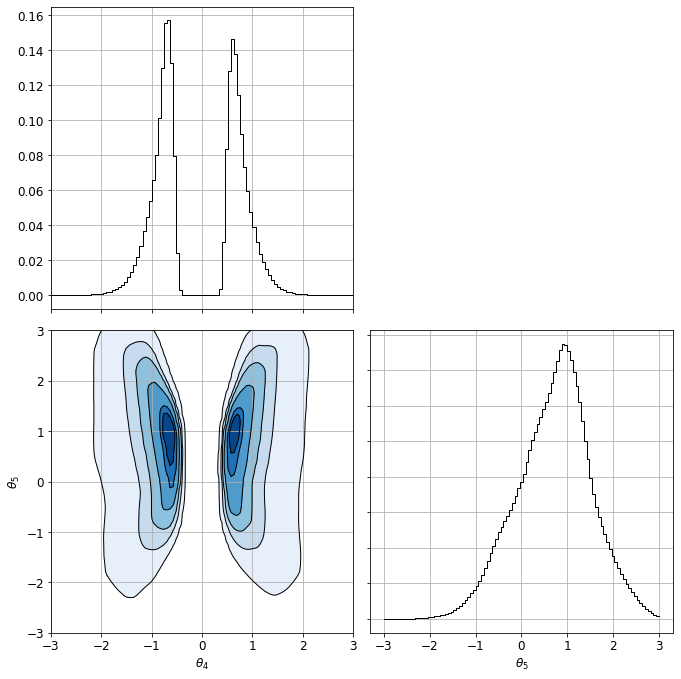

In [16]:
labels = [f'$\\theta_{{{i}}}$' for i in [4, 5]]

hists = pairify(hist_45)
fig = corner(hists, low[mask], high[mask], labels=labels)

#### 3, 4 & 5

In [17]:
mask, nre = model[1]
mask = mask.cpu()

In [18]:
sampler = NRESampler(nre, simulator.subprior(mask), z_star, batch_size=2 ** 12)
hist_345 = sampler.histogram(100, low[mask], high[mask]).cpu()

In [19]:
hist_345.sum()

tensor(1.7292)

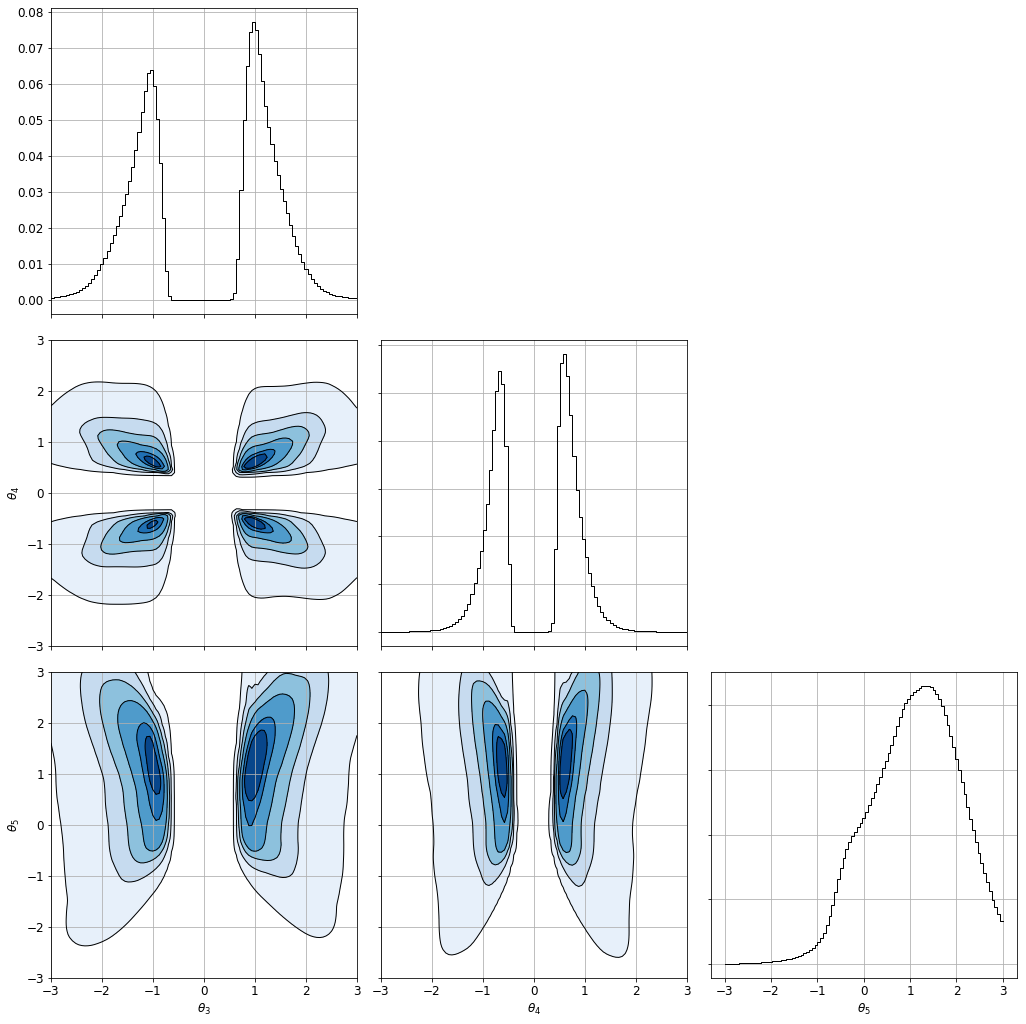

In [20]:
labels = [f'$\\theta_{{{i}}}$' for i in [3, 4, 5]]

hists = pairify(hist_345)
fig = corner(hists, low[mask], high[mask], labels=labels)

#### All

In [21]:
_, nre = model[2]

In [22]:
sampler = NRESampler(nre, simulator.prior, z_star, batch_size=2 ** 12, sigma=0.1)
samples = sampler(2 ** 6, 2 ** 14, groupby=2 ** 8)
hist = reduce_histogramdd(samples, 100, low, high, bounded=True, sparse=True, device='cpu')
hist = normalize(hist)

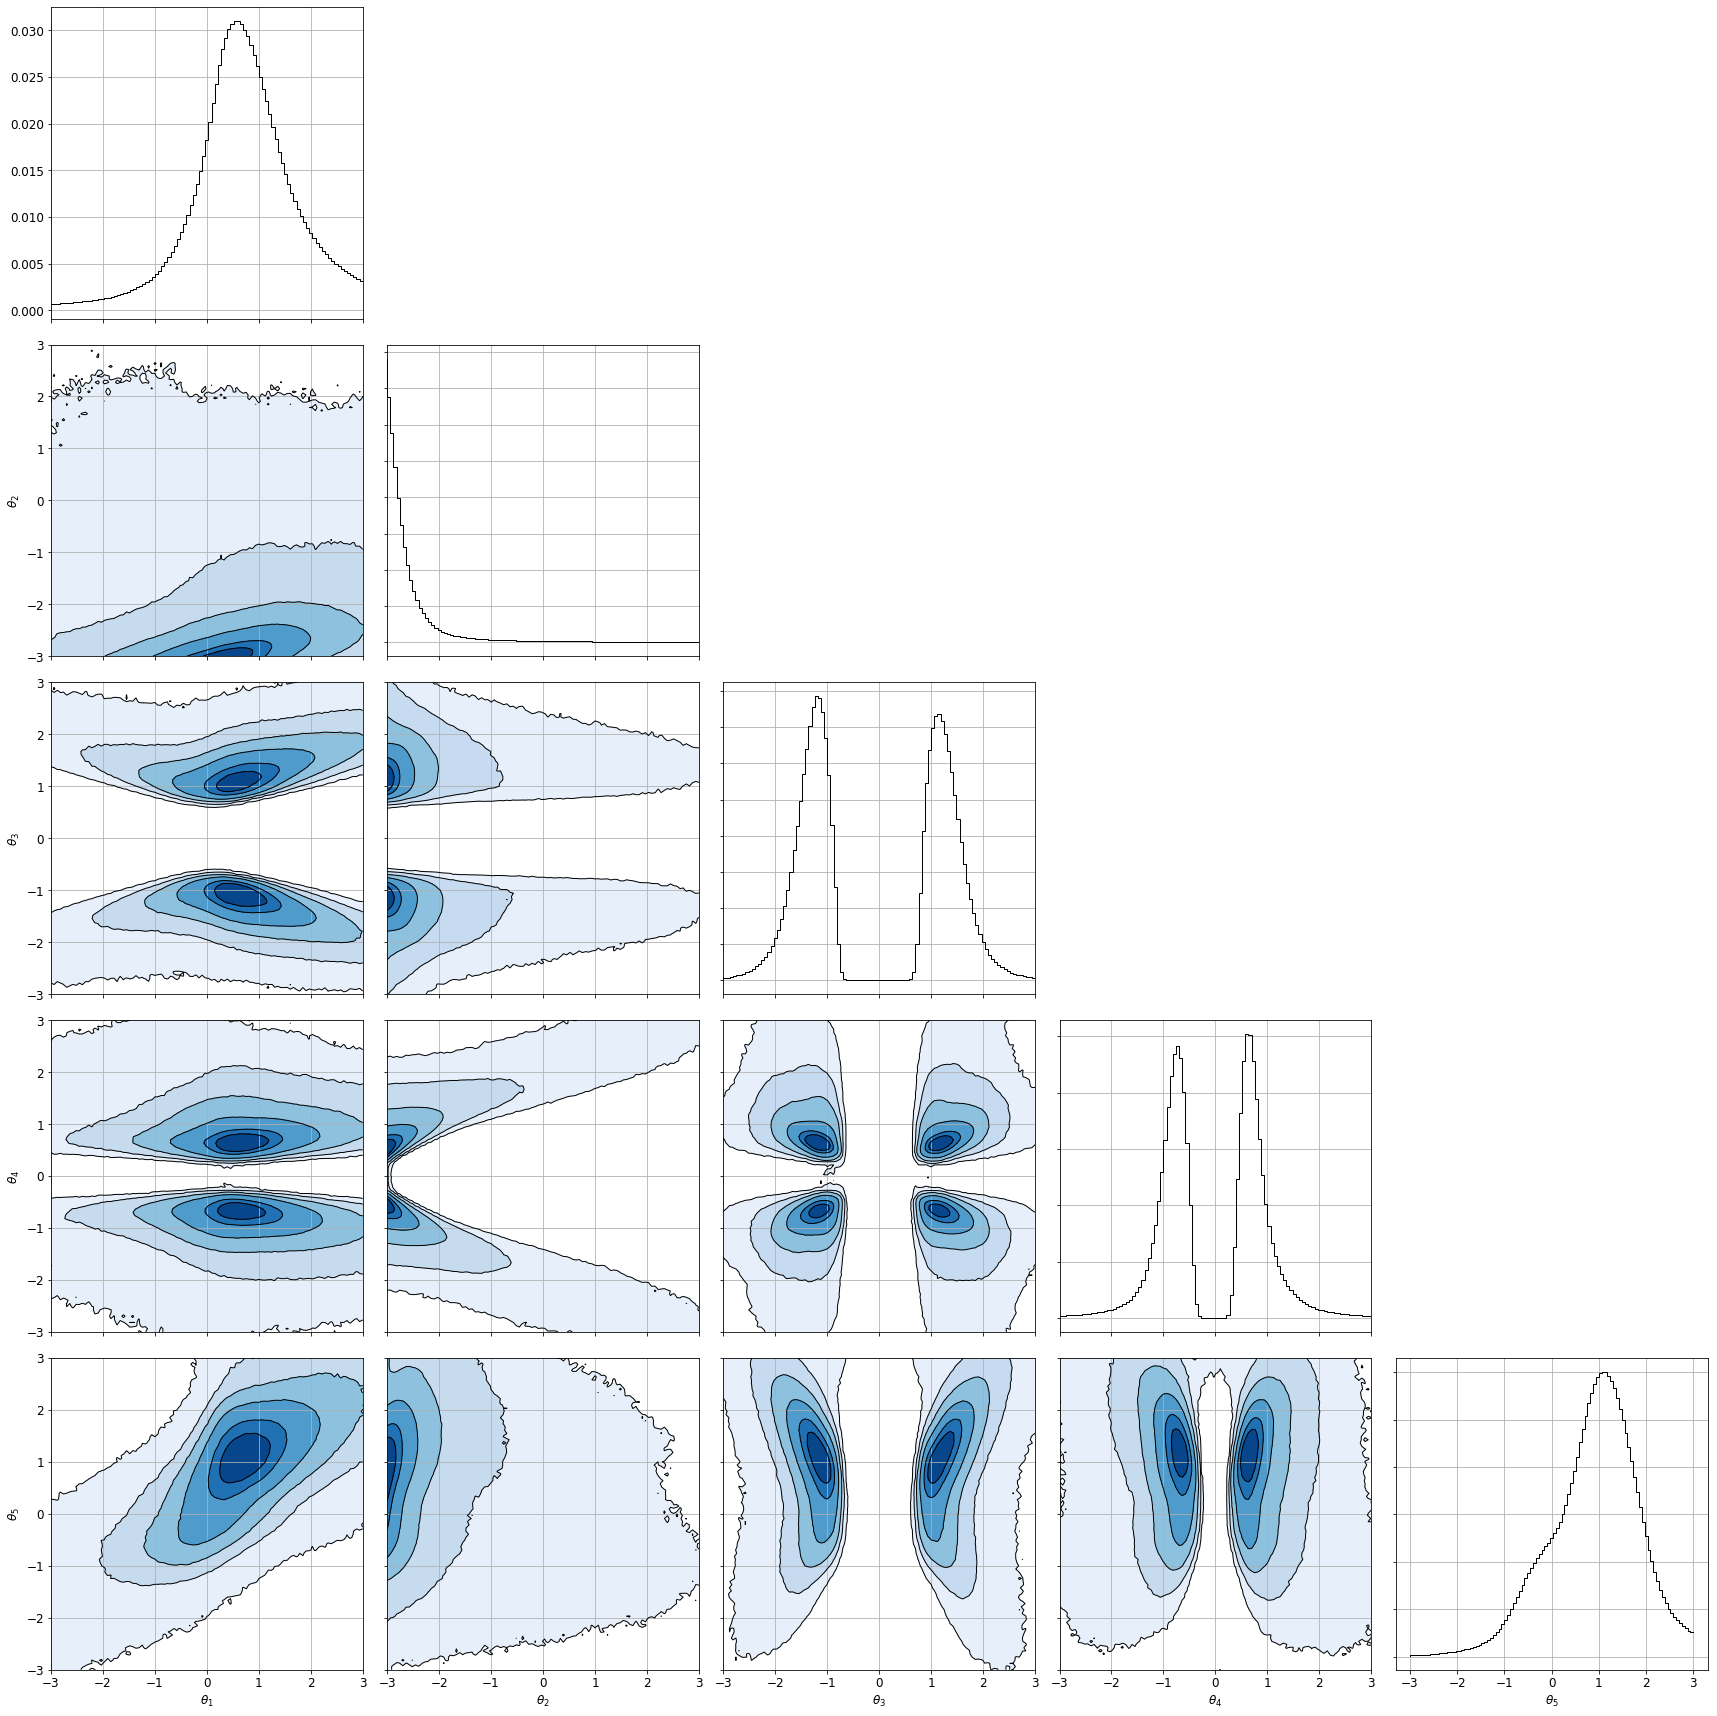

In [23]:
labels = [f'$\\theta_{{{i}}}$' for i in [1, 2, 3, 4, 5]]

hists = pairify(hist)
fig = corner(hists, low, high, labels=labels)